In [269]:
import numpy as np
from scipy.sparse import csc_array,csr_array,diags_array
from scipy.sparse import random_array
import matplotlib.pyplot as plt
from scipy.special import expit
from numpy import logaddexp
from tqdm.auto import tqdm
from scipy.optimize import minimize_scalar

In [270]:
from scipy.stats import Uniform


m = 1000
n = 500
samp = Uniform(a = -0.5,b = 0.5).sample


A = random_array((m,n),density = 0.2,data_sampler = lambda size:samp(size))
x_true = np.random.uniform(-0.1,1,n)

z_true = A@x_true

w = 100*np.ones(m)
y = np.random.binomial(w.astype(int),expit(z_true))/w

Q = 100 * diags_array(np.ones(n))

In [271]:
class LogisticNLL:
    def __init__(self, y, w):
        """
        y: array-like of binary responses (0 or 1)
        w: array-like of corresponding weights
        """
        self.y = np.array(y, dtype=float)
        self.w = np.array(w, dtype=float)

    def f(self, z):
        """
        Computes the negative weighted logistic log-likelihood:
            sum_i w_i [ log(1 + exp(z_i)) - y_i * z_i ]
        """
        z = np.array(z, dtype=float)
        return np.sum(self.w * (logaddexp(0, z) - self.y * z))

    def d1f(self, z):
        """
        Computes the first derivative (gradient) w.r.t. z:
            w_i [ sigma(z_i) - y_i ]
        """
        z = np.array(z, dtype=float)
        sig_z = expit(z)
        return self.w * (sig_z - self.y)

    def d2f(self, z):
        """
        Computes the second derivative (Hessian diagonal) w.r.t. z:
            w_i * sigma(z_i) * (1 - sigma(z_i))
        also using expit(z) for numerical stability.
        """
        z = np.array(z, dtype=float)
        sig_z = expit(z)
        hess_diag = self.w * sig_z * (1.0 - sig_z)
        return hess_diag

    def __call__(self, z):
        """
        By defining __call__, this object can be used like a function:
            phi(z) = phi.f(z)
        """
        return self.f(z)

In [272]:
nll = LogisticNLL(y,w)

In [273]:
nll(A@x_true)

51693.600258136816

In [274]:
x = np.zeros(n)
loss_vals = []
gradnorms = []
stepsizes = []
max_step = 1.
for i in tqdm(range(100)):
    z = A@x
    g = A.T@nll.d1f(z) + Q@x
    dz = A@g
    def line_obj(t):
        return nll(z-t*dz) + (x-t*g).T@(Q@(x-t*g))/2
    result = minimize_scalar(line_obj,bracket = (1e-3,1))#,options = {'maxiter':10})
    t = result.x
    if t>0.95*max_step:
        max_step = 1.1*max_step
    if t<0.7*max_step:
        max_step = 0.8*max_step
    stepsizes.append(t)
    x = x - t*g
    loss_vals.append(result.fun)
    gradnorms.append(np.max(np.abs(g)))
    

  0%|          | 0/100 [00:00<?, ?it/s]

In [275]:
# z = A@x
# g = A.T@nll.d1f(z)
# dz = A@g

# H = A.T@(A.multiply(nll.d2f(z).reshape(-1,1))).toarray()
# np.linalg.solve(H,g)

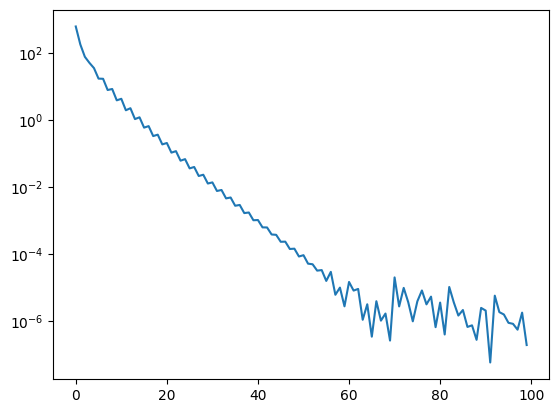

In [276]:
plt.plot(gradnorms)
plt.yscale("log")

In [277]:
x = x_true
z = A@x
g = A.T@nll.d1f(z)
dz = A@g

In [278]:
eps = 0.0001

(nll((A@(x + eps*g))) - nll(A@(x-eps*g)))/(2*eps)

157694.93972184137

In [279]:
np.sum(g**2)

157695.2471550542